# Calibrate HBV model with ERA5 forcing and GRDC observation

In this notebook the HBV model is calibrated using ERA5 forcing data (from notebook 1a) and GRDC observation data. The goal of this notebook is to provide an example of a calibration workflow. This is not intended as the best calibration possible. Using the HBV model for the entire Rhine catchment is silly anyway. This series of notebooks showcase the workflow to run a climate change impact analyses in eWaterCycle. 


In [1]:
# eWaterCycle dependencies. 
import ewatercycle.forcing
import ewatercycle.observation.grdc
import ewatercycle.analysis

# note that the model is a plugin which lives in its own repository.
# if you have not installed this model yet, you can do so by running
# !pip install ewatercycle-hbv
from ewatercycle.models import HBVLocal

# other dependencies
from pathlib import Path
from cartopy.io import shapereader
import pandas as pd
import numpy as np
from rich import print as rprint
from ipywidgets import IntProgress
from IPython.display import display




/opt/conda/envs/ewatercycle2/lib/python3.10/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


This cell contains all the info on the experiment: where the data needed is found, which time periods to use.

In [2]:
#shapefile that describes the basin we want to study.
shapeFile = Path("/home/rhut/metaFiles") / "Rhine.shp"

#location to saved forcing results from previous notebook
path = Path.cwd()
forcing_path = path / "Forcing"
ERA5forcingLocation = forcing_path / "GRDCStation6335020ERA5" / "work" / "diagnostic" / "script"

#GRDC station ID for the observation station
grdc_station_id = "6335020"  # GRDC station ID
basin_name = "Rhine"

#period of interest. Make sure that GRDC data is available for this period and that it matches your forcing data
experiment_start_time="2000-01-01T00:00:00Z"
experiment_end_time="2005-12-31T00:00:00Z"

#calibration period
calibration_start_time="2001-01-01T00:00:00Z"
calibration_end_time="2005-12-31T00:00:00Z"

Forcing was created in the previous notebook and loaded here

In [3]:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(ERA5forcingLocation)
rprint(ERA5_forcing)

LumpedMakkinkForcing(
    start_time='2000-01-01T00:00:00Z',
    end_time='2005-12-31T00:00:00Z',
    directory=PosixPath('/home/rhut/repos/ewatercycle-climatechangeimpact/Forcing/GRDCStation6335020ERA5/work/diagn
ostic/script'),
    shape=PosixPath('/home/rhut/repos/ewatercycle-climatechangeimpact/Forcing/GRDCStation6335020ERA5/work/diagnosti
c/script/Rhine.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_2000-2005.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_2000-2005.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_2000-2005.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

In [4]:
start_calibration = str(pd.to_datetime(ERA5_forcing.start_time) + pd.to_timedelta(366, unit='d'))

## Create multiple HBV models with different parameters

because in eWaterCycle models are objects, we can create arrays of models. In this way, we can quickly create an array of multiple models. In case of models we call this: 'an ensemble of models'. Each model (called 'ensemble member') will be given its own parameters. So before we make the ensmeble, we have to create a set of parameters that we want to give to them. Here we just use random (Monte Carlo) sampling of the entire parameter space. This can be expended easily into more complex calibration algorithms.

In [5]:
## Array of initial storage terms 
##              Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5, 0])

## meta data on the parameters and storages. Note that the first two arrays are for plotting
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]


In [6]:
#The number of ensemble members in our ensemble
N = 100

## Array of parameters min/max bounds 
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])

#create empty array to fill 
parameters = np.zeros([len(p_min_initial), N])

#fill with random values bounded by the min and max given above.
for param in range(len(p_min_initial)):
    parameters[param,:] = np.random.uniform(p_min_initial[param],p_max_initial[param],N)


The cell below creates the ensemble of model objects and initializes them all. It is essential to give them a pre-defined cfg_dir because otherwise eWaterCycle gives them a cfg_dir with a timestamp, which if more than one per second is created, results in errors.

In [7]:
ensemble = []

for counter in range(N): 
    ensemble.append(HBVLocal(forcing=ERA5_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = ','.join([str(p) for p in parameters[:,counter]]),
                            initial_storage=','.join([str(s) for s in s_0]),
                            cfg_dir = "configFiles/hbv_ensembleMember_" + str(counter),
                               )
    ensemble[counter].initialize(config_file)

/home/rhut/.local/lib/python3.10/site-packages/HBV/HBV_bmi.py:54: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
/home/rhut/.local/lib/python3.10/site-packages/HBV/HBV_bmi.py:54: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values

## Observations and objective function
we will compare each model output to observations and we need some sort of objective function to judge if the output is any good and thus determine which parameters are good for this region. I provide a basic mean absolute difference objective function here to show how one can add ones own. However, objective functions from packages like hydrostats can also be used. 

In [8]:
#Loading the GRDS observations
observations_df, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=ERA5_forcing.start_time,
    end_time=ERA5_forcing.end_time,
)
grdc_obs = observations_df.rename(columns={"streamflow": "Observations from GRDC"})
grdc_lon = metadata["grdc_longitude_in_arc_degree"]
grdc_lat = metadata["grdc_latitude_in_arc_degree"]

Remember from the previous notebook that we need the area of the catchment to calculate discharge in m3/s instead of mm/day. This time, we will do that conversion directly when we ask discharge from the model.

In [9]:
shapeObject = shapereader.Reader(shapeFile.absolute())
record = next(shapeObject.records())
shape_area = record.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", shape_area)

The catchment area is: 163122500000.0


Here we define the objective function

In [10]:
def calibrationObjective(modelOutput,observation,start_calibration,end_calibration):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference

    diff = hydro_data['Observations from GRDC'] - hydro_data['model output']
    absDiff = np.abs(diff)
    meanAbsDiff = np.mean(absDiff)

    return meanAbsDiff
  

Now we run the entire ensemble. Note that in theory this loop can be run in parallel. If you have access to many cores (or a supercomputer), this loop can be speed up considerably! For HBV this is not really a problem, but when doing calibration with larger models, this is a must.

In [11]:
#an object to show a progress bar, since this can take a while:
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar

#an empty array to store the results in
objectives = []

#loop over all ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q") * shape_area / (1000 * 86400)
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))
    
    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective(discharge_dataframe,grdc_obs,start_calibration,ERA5_forcing.end_time)
    objectives.append(objective_this_model)

    #it is good practice to remove any variable you don't need anymore to save memory.
    del Q_m, time, discharge_dataframe, objective_this_model

    #update progress bar
    f.value += 1
    

IntProgress(value=0)

In [12]:
#finaly, just like before, we remove the models themselves to save up space and memory.
for ensembleMember in ensemble:
    ensembleMember.finalize()

## analyse results
We now have objective function results for all ensemble members! Let's make some plots!

In [13]:
import matplotlib.pyplot as plt

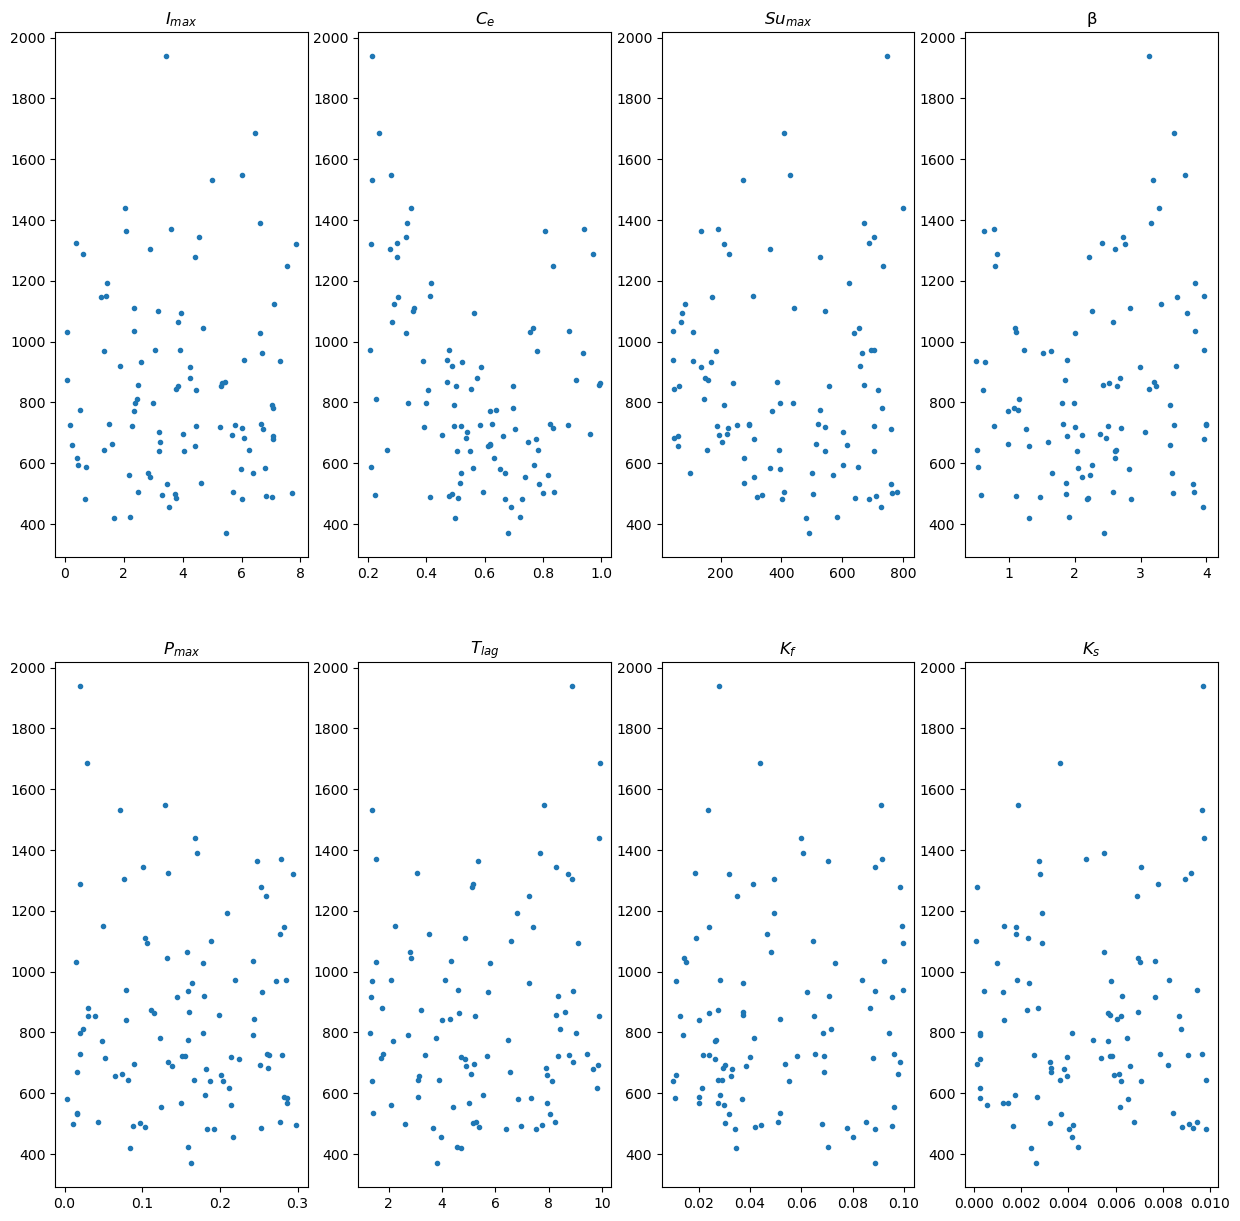

In [14]:
xFigNr = 2
yFigNr = 4

fig, axs = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

for xFig in range(xFigNr):
    for yFig in range(yFigNr):
        paramCounter = xFig*yFigNr + yFig
        axs[xFig,yFig].plot(parameters[paramCounter,:],objectives,'.')
        axs[xFig,yFig].set_title(p_names[paramCounter])


In the cell below we determine which of the model runs has the lowest mean absolute difference to the observations. We store this in a csv file for easy reading in the next notebook.

In [15]:
#let's also show the minimal values:
parameters_minimum_index = np.argmin(np.array(objectives))

parameters_minimum = parameters[:,parameters_minimum_index]

np.savetxt("calibration.csv", parameters_minimum, delimiter=",")

print(parameters_minimum)

[5.47825688e+00 6.80794043e-01 4.91050067e+02 2.44234273e+00
 1.63259937e-01 3.81204705e+00 8.87461454e-02 2.63979061e-03
 4.41831188e+00]


## Note on files

Each model now has its own directory in the configFiles directory. If everything goes well, these are deleted with the ```finalize()``` command above. If however due to an error, they persist, you may not be able to create a new ensemble. In that case, uncomment the line in the cell below and run that. But be careful! this will remove all the files in the configFiles directory.

In [16]:
#!rm -r configFiles/*